# Hello World
This notebook walks through basic code examples of integrating xGT with Neo4j, pandas, networkx, and jgraph

## xgt_neo4j_connector
xgt_neo4j_connector can be installed with: `python -m pip install -e git+https://github.com/trovares/xgt_neo4j_connector.git#egg=xgt_neo4j_connector`

## Connect
Connect to xGT and the Neo4j database

In [1]:
from xgt_neo4j_connector import Neo4jConnector
import xgt

xgt_server = xgt.Connection()
xgt_server.set_default_namespace('neo4j')
database = "test"

c=Neo4jConnector(xgt_server, neo4j_auth=('neo4j', 'foo'), neo4j_database=database)

In [2]:
with c.neo4j_driver.session(database=database) as session:
    session.run("MATCH (n) DETACH DELETE n")

## Create a graph in Neo4j

In [3]:
with c.neo4j_driver.session(database=database) as session:
    end = 5
    session.run('create (a:Person{id:0})')
    for i in range(0, end):
        session.run(f'match(a:Person) where a.id = {i} create (a)-[:Knows]->(:Person{{id:{i + 1}}})')
    session.run('match(a:Person), (b:Person) where a.id = 2 and b.id = 0 create (a)-[:Knows]->(b)')

## Transfer data to xGT
Transfers data associated with edge, `Knows`, including the associated vertices

In [4]:
c.transfer_from_neo4j_to_xgt_for(edges=["Knows"])

Copy data for vertex Person into schema: {'schema': [['neo4j_id', 'int'], ['id', 'int']], 'neo4j_schema': [['neo4j_id', 'INTEGER'], ['id', 'Long']], 'key': 'neo4j_id'}
Time to transfer: 0.25
Copy data for node Knows into schema: [{'schema': [['neo4j_source', 'int'], ['neo4j_target', 'int']], 'neo4j_schema': [['neo4j_source', 'INTEGER'], ['neo4j_target', 'INTEGER']], 'source': 'Person', 'target': 'Person', 'source_key': 'neo4j_source', 'target_key': 'neo4j_target'}]
Time to transfer: 0.01


## Cypher
Retrieve python query results

In [5]:
query = "match(a)-->()-->()-->(a) return a.id"

job = xgt_server.run_job(query)
print("xGT found the following nodes in a triangle: " + ','.join(str(row[0]) for row in job.get_data()))

xGT found the following nodes in a triangle: 2,1,0


## Pandas Data Frames
Convert results into a pandas dataframe

In [6]:
job.get_data_pandas()

,a_id
0,2
1,1
2,0


## NetworkX
Visualizing the graph with networkx

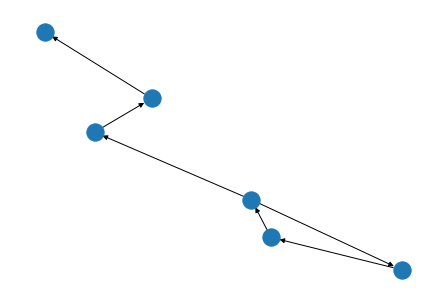

In [7]:
import networkx as nx

data =  xgt_server.run_job("match(a)-->(b) return a.id, b.id").get_data()
data = [tuple(x) for x in data]

DG = nx.DiGraph()
DG.add_edges_from(data)
nx.draw(DG)

## jgraph
Visualizing the graph with jgraph

In [8]:
import jgraph

data =  xgt_server.run_job("match(a)-->(b) return a.id, b.id").get_data()
data = [tuple(x) for x in data]
jgraph.draw(data)